### Importing Modules

In [4]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque, namedtuple

import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

### Defining of environment

In [5]:
env = gym.make("Taxi-v3")
env_action_space = env.action_space.n
env_state = env.reset()
action = env.action_space.sample()
a, b, c, d = env.decode(env_state)
next_state, reward, done, info = env.step(action)
all_destinations = env.unwrapped.locs
print(f"Initial state : {env_state}")
print(f"Decoded information of initial state => x coordinate of taxi : {a}, y coordinate of taxi : {b}, Passenger location : {c}, Destination : {d}")
print(f"Dictionary : {0} = {all_destinations[0]}, {1} = {all_destinations[1]}, {2} = {all_destinations[2]}, {3} = {all_destinations[3]}, {4} = In taxi")

Initial state : 241
Decoded information of initial state => x coordinate of taxi : 2, y coordinate of taxi : 2, Passenger location : 0, Destination : 1
Dictionary : 0 = (0, 0), 1 = (0, 4), 2 = (4, 0), 3 = (4, 3), 4 = In taxi


### Defining of Epsilon greedy policy for the main Q values and for the option specific Q values

In [6]:
def epsilon_greedy(q_values, state, epsilon):
  if random.uniform(0, 1) > epsilon:
    return np.argmax(q_values[state])
  else:
    return random.randint(0, 9)

def option_epsilon_greedy(q_values, state, epsilon):
    if random.uniform(0, 1) > epsilon:
      state_x, state_y, _, _ = env.decode(state)
      return np.argmax(q_values[state_x][state_y][:6])
    else:
      return random.randint(0, 5)

### Defining of SMDP function

In [7]:
def SMDP(q_values_SMDP, update_frequency_SMDP, options_q_values, alpha = 0.1, epsilon = 0.1):
  gamma = 0.9                                                                    # Gamma is a Fixed parameter
  scores = []                                                                    # For storing Episodic rewards
  for _ in tqdm(range(10000)):                                                   # Ran for 10000 episodes
    state = env.reset()
    done = False
    ep_reward = 0
    while not done:
      action = epsilon_greedy(q_values_SMDP, state, epsilon)
      if action < 6:                                                             # Updation when primitive actions are chosen
        next_state, reward, done, _ = env.step(action)
        q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
        update_frequency_SMDP[state][action] += 1
        ep_reward += reward
        state = next_state
      else:                                                                      # Updation when options where chosen
        if action == 6:                                                          # Option for making the taxi to move to Red location
          destination = env.unwrapped.locs[0]
          q = options_q_values[6]
        elif action == 7:                                                        # Option for making the taxi to move to Green location
          destination = env.unwrapped.locs[1]
          q = options_q_values[7]
        elif action == 8:                                                        # Option for making the taxi to move to Yellow location
          destination = env.unwrapped.locs[2]
          q = options_q_values[8]
        else:                                                                    # Option for making the taxi to move to Blue location
          destination = env.unwrapped.locs[3]
          q = options_q_values[9]
        init_state = state                                                       # Storing the start state of the option for updating later
        rewards = []                                                             # Storing option specific rewards
        while True:
          opt_action = option_epsilon_greedy(q, state, epsilon)
          next_state, reward, done, _ = env.step(opt_action)
          state_x, state_y, _, _ = env.decode(state)
          next_state_x, next_state_y, _, _ = env.decode(next_state)
          rewards.append(reward)
                                                                                 # Updating the option specific q values
          q[state_x][state_y][opt_action] += alpha * (reward + gamma * np.max(q[next_state_x][next_state_y]) - q[state_x][state_y][opt_action])

          state = next_state
          x_taxi, y_taxi, passenger_loc, dest = env.decode(state)
          if x_taxi == destination[0] and y_taxi == destination[1]:              # Checking if the taxi has finished the execution of the option or not
            break
        R = 0
        for reward in rewards[::-1]:                                             # Calculating the return for the option
          R = reward + gamma * R
        ep_reward += R
                                                                                 # Updating the SMDP q value for the option
        q_values_SMDP[init_state][action] += alpha * (R + (gamma ** len(rewards)) * np.max(q_values_SMDP[state]) - q_values_SMDP[init_state][action])
        update_frequency_SMDP[init_state][action] += 1
    scores.append(ep_reward)
  return scores

In [8]:
alpha_list = [0.01, 0.05, 0.1]
epsilon_list = [0.01, 0.1]
dic = {}
for alpha in alpha_list:
  for epsilon in epsilon_list:
    q_values_SMDP = np.zeros((500, 10))
    update_frequency_SMDP = np.zeros((500, 10))
    options_q_values = {6 : np.zeros((5, 5, 6)), 7 : np.zeros((5, 5, 6)), 8 : np.zeros((5, 5, 6)), 9 : np.zeros((5, 5, 6))}
    scores = SMDP(q_values_SMDP, update_frequency_SMDP, options_q_values, alpha, epsilon)
    dic[(alpha, epsilon)] = np.sum(scores)

100%|██████████| 10000/10000 [00:20<00:00, 480.78it/s]


In [9]:
print(dic)

{(0.01, 0.01): -763271.4330757333, (0.01, 0.1): -880170.0882160926, (0.05, 0.01): -142756.76776814205, (0.05, 0.1): -241246.43612618165, (0.1, 0.01): -37824.79581942731, (0.1, 0.1): -126138.53659929252}


In [10]:
opt_par = max(dic.keys(), key = lambda x : dic[x])
print(f"The best parameter is {opt_par}")

The best parameter is (0.1, 0.01)


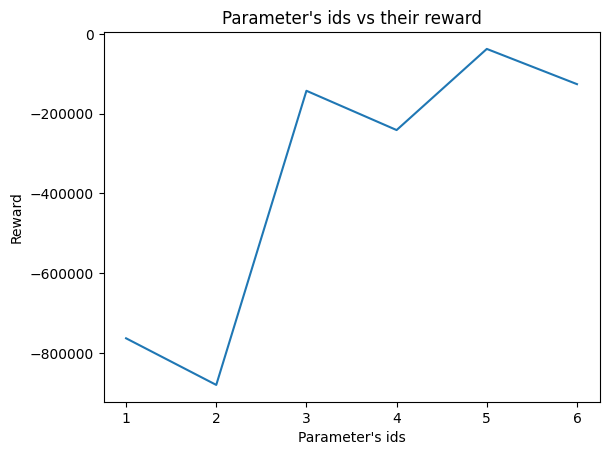

In [11]:
y = list(dic.values())
x =[]
for i in range(1, 7):
    x.append(i)
plt.plot(x, y)
plt.title("Parameter's ids vs their reward")
plt.xlabel("Parameter's ids")
plt.ylabel("Reward")
plt.show()